In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats

import statsmodels
from statsmodels.stats.anova import AnovaRM


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Nonlinear', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
roi_names = ['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPS']
n_rois = len(roi_names)

#### compute bootstrapped CIs for the correct/incorrect difference
on hard trials only

In [4]:
from multinomial_decoding import bootstrap_confidence
# bootstrap_confidence.bootstrap_correct_incorrect(n_boot_iter=1000)

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_sepcorrect_bootstrap.npy')
print(fn2load)
print(time.ctime(os.path.getmtime(fn2load)))

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_sepcorrect_boot = b['signedconf_hardtrials_sepcorrect_boot']

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_sepcorrect_bootstrap.npy
Sun Dec 15 09:46:44 2024


In [8]:
signedconf_hardtrials_sepcorrect_boot.shape

(10, 8, 3, 2, 1000)

In [9]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

-0.16862118650839755 0.3890607274551485


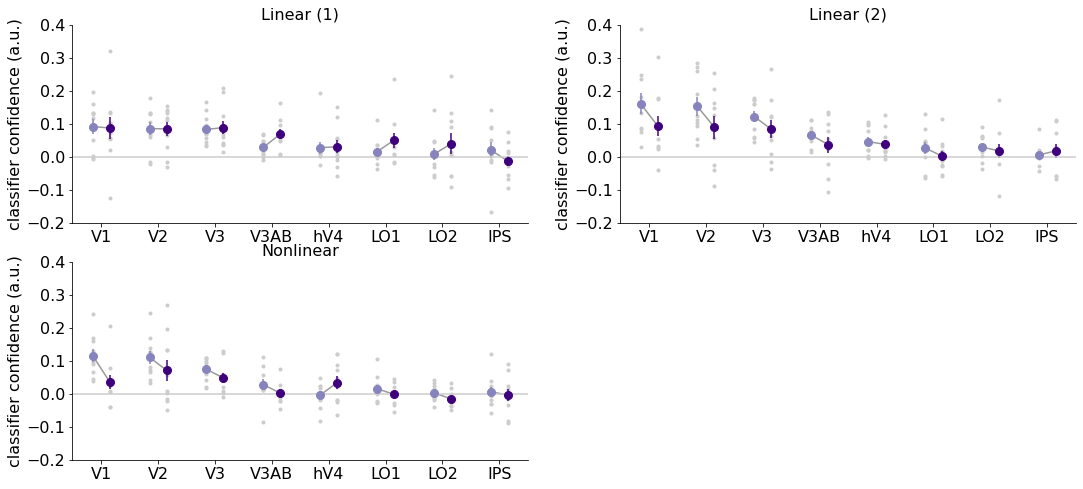

In [10]:
vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

print(np.min(vals), np.max(vals))

colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,8))

for ti in [0,1,2]:
    
    ax = plt.subplot(2,2,ti+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    for ci in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        plt.plot(x_ticks, meanvals[:,ti,ci], 'o', color=colors[ci], markersize=8, alpha=1)
        h = plt.errorbar(x_ticks, meanvals[:,ti,ci], \
                         semvals[:,ti,ci], \
                         xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,ti,:],'-',color=[0.6, 0.6, 0.6], zorder=-5)
        
        plt.plot(ri+x_jitter, vals[:,ri,ti,:].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
        # if non_overlapping[ri]:
        #     yval = np.max(cihigh[ri,ti,:])+0.02
        #     plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.40])
    # plt.ylim([-0.05, 0.20])
    
    plt.yticks(np.arange(-0.2, 0.4, 0.10))
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('classifier confidence (a.u.)')
    
    # plt.legend(lh,['subject correct','subject incorrect'])
    
    plt.title(task_names[ti])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
# plt.suptitle('Hard trials: classifier confidence')

figname = os.path.join(figfolder, 'multinomial_correct_vs_incorrect.pdf')
plt.savefig(figname)


In [22]:
tnames = ['linear1','linear2','checker']

for ti, taskname in enumerate(tnames):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,ti,:]

    anova_result = stats_utils.rmanova_2way(vals, ['ROI','Correctness'], \
                                            # do_shuffle=False);
                                            do_shuffle=True, n_iter=10000, rndseed = 143242)
    
    tablename = os.path.join(figfolder, 'decode_16way_correctness_rm_anova_%s.csv'%(taskname))
    
    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_correctness_rm_anova_linear1.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_correctness_rm_anova_linear2.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_correctness_rm_anova_checker.csv


In [11]:
tnames = ['linear1','linear2','checker']

for ti, taskname in enumerate(tnames):
    print(taskname)
    tablename = os.path.join(figfolder, 'decode_16way_correctness_rm_anova_%s.csv'%(taskname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print(anova_result)

linear1
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_correctness_rm_anova_linear1.csv
Thu Dec 12 13:21:17 2024
                  F Value  Num DF  Den DF    Pr > F  p (permutation)
ROI              4.904359     7.0    63.0  0.000183           0.0003
Correctness      0.396651     1.0     9.0  0.544479           0.5431
ROI:Correctness  0.983139     7.0    63.0  0.451564           0.4527
linear2
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_correctness_rm_anova_linear2.csv
Thu Dec 12 13:25:27 2024
                   F Value  Num DF  Den DF        Pr > F  p (permutation)
ROI              10.211319     7.0    63.0  1.789274e-08           0.0000
Correctness       6.332788     1.0     9.0  3.295720e-02           0.0314
ROI:Correctness   1.807194     7.0    63.0  1.014348e-01           0.0990
checker
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_correctness_rm_anova_checker.csv
Thu Dec 12 13:29:41 2024
                  F Val

In [12]:
for ti in range(3):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,ti,:]

    tstats_correctness = np.zeros((n_rois,),dtype=float)
    pvals_correctness = np.zeros((n_rois,),dtype=float)
    
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 3535445
    for rr in range(n_rois):

        c1_values = vals[:,rr,0]
        c2_values = vals[:,rr,1]

        p, t = stats_utils.paired_ttest_nonpar(c1_values, c2_values, \
                                               n_iter=10000, rndseed=rndseed+rr)    
        pvals_correctness[rr] = p
        tstats_correctness[rr] = t

        subj_diffs = c1_values - c2_values
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))


    corr_df = pd.DataFrame({'t-stat for correct > incorrect': tstats_correctness, \
                            'pvalue': pvals_correctness, \
                            'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    corr_df = corr_df.round(3)
    
    print('\n%s'%task_names[ti])
    print(corr_df)


Linear (1)
      t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                             0.107   0.921             6
V2                             0.036   0.976             6
V3                            -0.204   0.857             5
V3AB                          -2.310   0.034             8
hV4                           -0.125   0.908             7
LO1                           -1.174   0.307             6
LO2                           -0.950   0.385             6
IPS                            1.637   0.139             8

Linear (2)
      t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                             3.616   0.007             8
V2                             2.912   0.022             8
V3                             1.417   0.200             6
V3AB                           1.047   0.356             6
hV4                            0.790   0.480             6
LO1                            1.070   0.285             6
LO2                            0